In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import cm

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import argparse
import os
from tqdm import tqdm
import time

from net.aams import AttentionNet, Encoder, Decoder, SelfAttention
%load_ext autoreload
%autoreload 2

In [2]:
parser = argparse.ArgumentParser()
# Basic options
# parser.add_argument('--dataset_dir', type=str, default='./datasets/content_set/val2014',
#                     help='Directory path to a batch of content images')
# parser.add_argument('--dataset_dir', type=str, default='./datasets/style_set/val2014',
#                     help='Directory path to a batch of style images')
parser.add_argument('--dataset_dir', type=str, default='./datasets/content_style_mix_set/val2014',
                    help='Directory path to a batch of style images')


# training options
parser.add_argument('--save_dir', default='./models/content_style_mix',
                    help='Directory to save the model')
parser.add_argument('--log_dir', default='./logs',
                    help='Directory to save the log')
parser.add_argument('--lr', type=float, default=1e-4)
parser.add_argument('--lr_decay', type=float, default=5e-5)
parser.add_argument('--max_iter', type=int, default=80000)
parser.add_argument('--batch_size', type=int, default=8)
parser.add_argument('--n_threads', type=int, default=2)
parser.add_argument('--save_model_interval', type=int, default=100)
parser.add_argument('--start_iter', type=float, default=0)
parser.add_argument('--seperate', type=bool, default=False)
args = parser.parse_args('')

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

_R_MEAN = 123.68
_G_MEAN = 116.78
_B_MEAN = 103.94

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(size=(512, 512)),
        transforms.RandomCrop(256),
        transforms.ToTensor(),
        transforms.Normalize((_R_MEAN/255.0, _G_MEAN/255.0, _B_MEAN/255.0), (0.5, 0.5, 0.5))
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=(512, 512)),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize((_R_MEAN/255.0, _G_MEAN/255.0, _B_MEAN/255.0), (0.5, 0.5, 0.5))
    ]),
}

class FlatFolderDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform):
        super(FlatFolderDataset, self).__init__()
        self.root = root
        self.paths = os.listdir(self.root)
        self.transform = transform

    def __getitem__(self, index):
        path = self.paths[index]
        img = Image.open(os.path.join(self.root, path)).convert('RGB')
        img = self.transform(img)
        return img

    def __len__(self):
        return len(self.paths)

    def name(self):
        return 'FlatFolderDataset'

train_set = FlatFolderDataset(args.dataset_dir, data_transforms['train'])
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=args.batch_size,
    shuffle=True, num_workers=args.n_threads)
train_iter = iter(train_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])


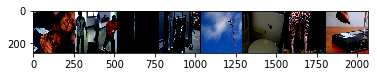

In [5]:

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images = dataiter.next()
print(images[0].size())
# show images
imshow(torchvision.utils.make_grid(images))


In [6]:
def get_optimizer(model, seperate):
    for param in model.encode.parameters():
        param.requires_grad = False
    if seperate == True:
        optimizer = torch.optim.Adam([
            {'params': model.self_attn_content.parameters()},
            {'params': model.self_attn_style.parameters()},
            {'params': model.content_decode.parameters()},
            {'params': model.style_decode.parameters()},
        ], lr=args.lr)
    else:
        optimizer = torch.optim.Adam([
            {'params': model.decode.parameters()},
            {'params': model.self_attn.parameters()},
        ], lr=args.lr)
    return optimizer

if(args.start_iter > 0):
    decoder = Decoder()
    decoder.load_state_dict(torch.load(args.save_dir + '/decoder_iter_' + str(args.start_iter) + '.pth'))
    attn = SelfAttention()
    attn.load_state_dict(torch.load(args.save_dir + '/attention_kernel_iter_' + str(args.start_iter) + '.pth'))
    
    state_dict = decoder.state_dict()
    for key in state_dict.keys():
        state_dict[key] = state_dict[key].to(device)
    state_dict = attn.state_dict()
    for key in state_dict.keys():
        state_dict[key] = state_dict[key].to(device)
    
    model = AttentionNet(seperate=args.seperate, attn=attn, decoder = decoder)
    optimizer = get_optimizer(model, args.seperate)
    optimizer.load_state_dict(torch.load(args.save_dir + '/optimizer_iter_' + str(args.start_iter) + '.pth'))
    for state in optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.cuda()
else:
    model = AttentionNet(seperate=args.seperate)
    optimizer = get_optimizer(model, args.seperate)

model.to(device)   
loss_seq = {'total': [], 'construct': [], 'percept': [], 'tv': [], 'attn': []}

In [7]:
def lastest_arverage_value(values, length=100):
    if len(values) < length:
        length = len(values)
    return sum(values[-length:])/length

def adjust_learning_rate(optimizer, iteration_count):
    """Imitating the original implementation"""
    lr = args.lr / (1.0 + args.lr_decay * iteration_count)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
reload_period = len(train_loader.dataset) / args.batch_size
for i in tqdm(range(args.start_iter, args.max_iter)):
    adjust_learning_rate(optimizer, iteration_count=i)
    
    if (i - args.start_iter)%reload_period == 0:
        train_loader = torch.utils.data.DataLoader(
            train_set, batch_size=args.batch_size,
            shuffle=True, num_workers=args.n_threads)
        train_iter = iter(train_loader)
        
    if args.seperate == False:
        content_images = next(train_iter).to(device)
        losses, _, _ = model(content_images)
        
    total_loss = losses['total']
    
    for name, vals in loss_seq.items():
        loss_seq[name].append(losses[name].item())
        
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if (i + 1) % args.save_model_interval == 0 or (i + 1) == args.max_iter:
        print("%s: Iteration: [%d/%d]\tRecon Loss: %2.4f\tPercept Loss: %2.4f\tTV Loss: %2.4f\tAttn Loss: %2.4f\tTotal: %2.4f"%(time.ctime(),i+1, 
                args.max_iter, lastest_arverage_value(loss_seq['construct']), lastest_arverage_value(loss_seq['percept']), 
                lastest_arverage_value(loss_seq['tv']), lastest_arverage_value(loss_seq['attn']), lastest_arverage_value(loss_seq['total'])))
        if args.seperate == False:
            state_dict = model.decode.state_dict()
            for key in state_dict.keys():
                state_dict[key] = state_dict[key].to(torch.device('cpu'))
            torch.save(state_dict,
                       '{:s}/decoder_iter_{:d}.pth'.format(args.save_dir,
                                                               i + 1))
            state_dict = model.self_attn.state_dict()
            for key in state_dict.keys():
                state_dict[key] = state_dict[key].to(torch.device('cpu'))
            torch.save(state_dict,
                       '{:s}/attention_kernel_iter_{:d}.pth'.format(args.save_dir,
                                                               i + 1))
            state_dict = optimizer.state_dict()
            torch.save(state_dict,
                       '{:s}/optimizer_iter_{:d}.pth'.format(args.save_dir,
                                                               i + 1))
        else:
            pass
    
    

  0%|          | 99/80000 [00:34<7:42:13,  2.88it/s]

Sun Jun 28 06:09:34 2020: Iteration: [100/80000]	Recon Loss: 4482.5308	Percept Loss: 175140.1208	TV Loss: 4.6605	Attn Loss: 1806423.1087	Total: 11058550.7200


  0%|          | 199/80000 [01:08<7:43:40,  2.87it/s]

Sun Jun 28 06:10:08 2020: Iteration: [200/80000]	Recon Loss: 3137.0917	Percept Loss: 135987.4241	TV Loss: 5.2339	Attn Loss: 1017830.1038	Total: 6274391.2950


  0%|          | 299/80000 [01:44<7:50:48,  2.82it/s]

Sun Jun 28 06:10:44 2020: Iteration: [300/80000]	Recon Loss: 2666.7212	Percept Loss: 116119.1171	TV Loss: 6.3338	Attn Loss: 586787.7750	Total: 3663576.3025


  0%|          | 399/80000 [02:19<7:50:07,  2.82it/s]

Sun Jun 28 06:11:19 2020: Iteration: [400/80000]	Recon Loss: 2388.9928	Percept Loss: 100490.9039	TV Loss: 6.9129	Attn Loss: 270131.6566	Total: 1745239.9000


  1%|          | 499/80000 [02:55<7:50:39,  2.82it/s]

Sun Jun 28 06:11:55 2020: Iteration: [500/80000]	Recon Loss: 2301.2266	Percept Loss: 93559.8736	TV Loss: 7.2729	Attn Loss: 163403.7454	Total: 1097067.3350


  1%|          | 599/80000 [03:31<7:50:05,  2.82it/s]

Sun Jun 28 06:12:31 2020: Iteration: [600/80000]	Recon Loss: 1959.6229	Percept Loss: 91834.4225	TV Loss: 8.0038	Attn Loss: 141463.7641	Total: 960293.2756


  1%|          | 699/80000 [04:06<7:47:29,  2.83it/s]

Sun Jun 28 06:13:06 2020: Iteration: [700/80000]	Recon Loss: 1869.7291	Percept Loss: 88598.6321	TV Loss: 8.0559	Attn Loss: 120452.8684	Total: 830093.6875


  1%|          | 799/80000 [04:42<7:49:30,  2.81it/s]

Sun Jun 28 06:13:42 2020: Iteration: [800/80000]	Recon Loss: 1757.9207	Percept Loss: 87996.9243	TV Loss: 8.3260	Attn Loss: 114426.2314	Total: 792216.7738


  1%|          | 899/80000 [05:17<7:47:09,  2.82it/s]

Sun Jun 28 06:14:17 2020: Iteration: [900/80000]	Recon Loss: 1629.0679	Percept Loss: 80883.8643	TV Loss: 8.4370	Attn Loss: 100425.0988	Total: 699809.5044


  1%|          | 999/80000 [05:53<7:45:24,  2.83it/s]

Sun Jun 28 06:14:53 2020: Iteration: [1000/80000]	Recon Loss: 1515.1684	Percept Loss: 79548.0747	TV Loss: 8.5285	Attn Loss: 95957.1126	Total: 670527.7231


  1%|▏         | 1099/80000 [06:29<7:46:31,  2.82it/s]

Sun Jun 28 06:15:29 2020: Iteration: [1100/80000]	Recon Loss: 1425.4876	Percept Loss: 78575.0597	TV Loss: 8.7870	Attn Loss: 89491.9687	Total: 629869.6184


  1%|▏         | 1199/80000 [07:04<7:52:52,  2.78it/s]

Sun Jun 28 06:16:04 2020: Iteration: [1200/80000]	Recon Loss: 1335.3093	Percept Loss: 78963.2546	TV Loss: 9.0302	Attn Loss: 83979.6082	Total: 596284.3034


  2%|▏         | 1299/80000 [07:40<7:44:35,  2.82it/s]

Sun Jun 28 06:16:40 2020: Iteration: [1300/80000]	Recon Loss: 1301.0312	Percept Loss: 73654.5946	TV Loss: 8.9050	Attn Loss: 77807.2548	Total: 553597.4834


  2%|▏         | 1399/80000 [08:16<7:42:41,  2.83it/s]

Sun Jun 28 06:17:16 2020: Iteration: [1400/80000]	Recon Loss: 1249.7828	Percept Loss: 73825.4713	TV Loss: 9.0035	Attn Loss: 74323.1001	Total: 532351.9359


  2%|▏         | 1499/80000 [08:51<7:53:35,  2.76it/s]

Sun Jun 28 06:17:51 2020: Iteration: [1500/80000]	Recon Loss: 1201.3441	Percept Loss: 73202.3016	TV Loss: 9.0706	Attn Loss: 70226.3773	Total: 506664.7125


  2%|▏         | 1599/80000 [09:27<7:42:38,  2.82it/s]

Sun Jun 28 06:18:27 2020: Iteration: [1600/80000]	Recon Loss: 1128.4774	Percept Loss: 69247.9266	TV Loss: 8.8781	Attn Loss: 66038.6514	Total: 476853.3897


  2%|▏         | 1699/80000 [10:03<7:41:47,  2.83it/s]

Sun Jun 28 06:19:03 2020: Iteration: [1700/80000]	Recon Loss: 1061.5150	Percept Loss: 69092.4994	TV Loss: 9.1203	Attn Loss: 62555.4764	Total: 455131.7106


  2%|▏         | 1799/80000 [10:39<7:46:19,  2.79it/s]

Sun Jun 28 06:19:39 2020: Iteration: [1800/80000]	Recon Loss: 1065.1709	Percept Loss: 71805.5455	TV Loss: 9.5277	Attn Loss: 59875.8360	Total: 441807.5475


  2%|▏         | 1899/80000 [11:15<7:39:47,  2.83it/s]

Sun Jun 28 06:20:15 2020: Iteration: [1900/80000]	Recon Loss: 1023.3996	Percept Loss: 69976.1913	TV Loss: 9.5469	Attn Loss: 57133.8364	Total: 423108.6750


  2%|▏         | 1999/80000 [11:50<7:43:24,  2.81it/s]

Sun Jun 28 06:20:50 2020: Iteration: [2000/80000]	Recon Loss: 975.3037	Percept Loss: 68534.4368	TV Loss: 9.4103	Attn Loss: 54204.9271	Total: 403611.1397


  3%|▎         | 2099/80000 [12:26<7:45:18,  2.79it/s]

Sun Jun 28 06:21:26 2020: Iteration: [2100/80000]	Recon Loss: 953.6059	Percept Loss: 67040.8017	TV Loss: 9.3208	Attn Loss: 52648.4584	Total: 392560.8209


  3%|▎         | 2199/80000 [13:02<7:44:01,  2.79it/s]

Sun Jun 28 06:22:02 2020: Iteration: [2200/80000]	Recon Loss: 949.1426	Percept Loss: 68235.1465	TV Loss: 9.7157	Attn Loss: 49468.8586	Total: 374636.8787


  3%|▎         | 2234/80000 [13:15<7:42:55,  2.80it/s]/home/dehezhang2/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (131790400 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
  3%|▎         | 2299/80000 [13:39<7:37:17,  2.83it/s] 

Sun Jun 28 06:22:39 2020: Iteration: [2300/80000]	Recon Loss: 905.9228	Percept Loss: 65615.4962	TV Loss: 9.5045	Attn Loss: 47628.9354	Total: 360543.3808


  3%|▎         | 2399/80000 [14:15<7:40:48,  2.81it/s]

Sun Jun 28 06:23:15 2020: Iteration: [2400/80000]	Recon Loss: 896.9389	Percept Loss: 67463.4582	TV Loss: 9.6911	Attn Loss: 45284.7087	Total: 348238.0106


  3%|▎         | 2499/80000 [14:51<7:45:38,  2.77it/s]

Sun Jun 28 06:23:51 2020: Iteration: [2500/80000]	Recon Loss: 879.0520	Percept Loss: 66999.8371	TV Loss: 9.8794	Attn Loss: 43597.4464	Total: 337473.8302


  3%|▎         | 2599/80000 [15:26<7:37:37,  2.82it/s]

Sun Jun 28 06:24:26 2020: Iteration: [2600/80000]	Recon Loss: 862.4663	Percept Loss: 64370.8795	TV Loss: 9.7239	Attn Loss: 40884.8411	Total: 318401.8284


  3%|▎         | 2699/80000 [16:02<7:51:00,  2.74it/s]

Sun Jun 28 06:25:02 2020: Iteration: [2700/80000]	Recon Loss: 838.0813	Percept Loss: 63761.2500	TV Loss: 9.6072	Attn Loss: 39381.2166	Total: 308525.4350


  3%|▎         | 2799/80000 [16:38<8:03:58,  2.66it/s]

Sun Jun 28 06:25:38 2020: Iteration: [2800/80000]	Recon Loss: 818.2728	Percept Loss: 62996.2142	TV Loss: 9.6679	Attn Loss: 38126.7127	Total: 300035.8970


  4%|▎         | 2899/80000 [17:14<7:36:20,  2.82it/s]

Sun Jun 28 06:26:14 2020: Iteration: [2900/80000]	Recon Loss: 832.7735	Percept Loss: 65623.8609	TV Loss: 9.9927	Attn Loss: 37033.1028	Total: 296250.1402


  4%|▎         | 2999/80000 [17:50<7:33:52,  2.83it/s]

Sun Jun 28 06:26:50 2020: Iteration: [3000/80000]	Recon Loss: 813.9074	Percept Loss: 62561.8990	TV Loss: 9.7483	Attn Loss: 34878.2009	Total: 280067.6616


  4%|▍         | 3099/80000 [18:26<7:36:30,  2.81it/s]

Sun Jun 28 06:27:26 2020: Iteration: [3100/80000]	Recon Loss: 815.4030	Percept Loss: 64897.5586	TV Loss: 10.0620	Attn Loss: 34198.8332	Total: 278345.2073


  4%|▍         | 3199/80000 [19:02<7:35:56,  2.81it/s]

Sun Jun 28 06:28:02 2020: Iteration: [3200/80000]	Recon Loss: 803.4332	Percept Loss: 64076.0886	TV Loss: 10.1275	Attn Loss: 32208.0641	Total: 265460.0794


  4%|▍         | 3299/80000 [19:37<7:35:26,  2.81it/s]

Sun Jun 28 06:28:37 2020: Iteration: [3300/80000]	Recon Loss: 769.5929	Percept Loss: 61002.3625	TV Loss: 9.8271	Attn Loss: 30931.2071	Total: 254383.8048


  4%|▍         | 3399/80000 [20:13<7:40:25,  2.77it/s]

Sun Jun 28 06:29:13 2020: Iteration: [3400/80000]	Recon Loss: 762.9917	Percept Loss: 59855.6452	TV Loss: 9.8041	Attn Loss: 29145.3001	Total: 242455.4045


  4%|▍         | 3499/80000 [20:49<7:33:46,  2.81it/s]

Sun Jun 28 06:29:49 2020: Iteration: [3500/80000]	Recon Loss: 773.0853	Percept Loss: 60193.3180	TV Loss: 9.8134	Attn Loss: 28328.5296	Total: 237993.4825


  4%|▍         | 3599/80000 [21:25<7:41:58,  2.76it/s]

Sun Jun 28 06:30:25 2020: Iteration: [3600/80000]	Recon Loss: 741.0362	Percept Loss: 60212.6020	TV Loss: 9.9064	Attn Loss: 27227.9323	Total: 231089.6217


  5%|▍         | 3699/80000 [22:01<7:29:02,  2.83it/s]

Sun Jun 28 06:31:01 2020: Iteration: [3700/80000]	Recon Loss: 743.7252	Percept Loss: 60654.0881	TV Loss: 9.9903	Attn Loss: 26475.1164	Total: 227041.9433


  5%|▍         | 3799/80000 [22:36<7:37:15,  2.78it/s]

Sun Jun 28 06:31:36 2020: Iteration: [3800/80000]	Recon Loss: 774.0706	Percept Loss: 61488.6584	TV Loss: 10.1491	Attn Loss: 25181.5449	Total: 220420.1241


  5%|▍         | 3899/80000 [23:12<7:57:46,  2.65it/s]

Sun Jun 28 06:32:12 2020: Iteration: [3900/80000]	Recon Loss: 750.8908	Percept Loss: 61552.7088	TV Loss: 10.2323	Attn Loss: 24266.1073	Total: 214760.5833


  5%|▍         | 3913/80000 [23:17<7:45:17,  2.73it/s]/home/dehezhang2/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
  5%|▍         | 3999/80000 [23:48<7:35:18,  2.78it/s]

Sun Jun 28 06:32:48 2020: Iteration: [4000/80000]	Recon Loss: 730.6677	Percept Loss: 58845.9378	TV Loss: 10.0640	Attn Loss: 22992.2034	Total: 204206.4764


  5%|▌         | 4099/80000 [24:24<7:29:11,  2.82it/s]

Sun Jun 28 06:33:24 2020: Iteration: [4100/80000]	Recon Loss: 706.1237	Percept Loss: 58370.1385	TV Loss: 9.9415	Attn Loss: 22050.5897	Total: 197834.3292


  5%|▌         | 4199/80000 [25:00<7:31:57,  2.80it/s]

Sun Jun 28 06:34:00 2020: Iteration: [4200/80000]	Recon Loss: 729.5798	Percept Loss: 58667.7139	TV Loss: 10.2087	Attn Loss: 20944.5265	Total: 191732.7569


  5%|▌         | 4299/80000 [25:36<7:36:39,  2.76it/s]

Sun Jun 28 06:34:36 2020: Iteration: [4300/80000]	Recon Loss: 719.4855	Percept Loss: 57464.2537	TV Loss: 10.0503	Attn Loss: 20236.3303	Total: 186177.5923


  5%|▌         | 4399/80000 [26:12<7:44:17,  2.71it/s]

Sun Jun 28 06:35:12 2020: Iteration: [4400/80000]	Recon Loss: 717.7779	Percept Loss: 58066.4009	TV Loss: 10.0034	Attn Loss: 19539.2150	Total: 182579.5045


  6%|▌         | 4499/80000 [26:48<7:34:23,  2.77it/s]

Sun Jun 28 06:35:48 2020: Iteration: [4500/80000]	Recon Loss: 697.6138	Percept Loss: 57937.7893	TV Loss: 10.2880	Attn Loss: 18550.3949	Total: 176319.1769


  6%|▌         | 4599/80000 [27:24<7:40:01,  2.73it/s]

Sun Jun 28 06:36:24 2020: Iteration: [4600/80000]	Recon Loss: 715.4095	Percept Loss: 57265.0318	TV Loss: 10.1661	Attn Loss: 17713.7177	Total: 170803.0944


  6%|▌         | 4699/80000 [28:00<7:34:56,  2.76it/s]

Sun Jun 28 06:37:00 2020: Iteration: [4700/80000]	Recon Loss: 722.5551	Percept Loss: 58470.2075	TV Loss: 10.3017	Attn Loss: 16900.0438	Total: 167199.0389


  6%|▌         | 4799/80000 [28:36<7:29:40,  2.79it/s]

Sun Jun 28 06:37:36 2020: Iteration: [4800/80000]	Recon Loss: 711.7656	Percept Loss: 57414.4819	TV Loss: 10.0642	Attn Loss: 15910.5548	Total: 160096.1082


  6%|▌         | 4899/80000 [29:12<7:28:05,  2.79it/s]

Sun Jun 28 06:38:12 2020: Iteration: [4900/80000]	Recon Loss: 699.9587	Percept Loss: 56779.8834	TV Loss: 10.2057	Attn Loss: 14959.4062	Total: 153637.9652


  6%|▌         | 4999/80000 [29:48<7:28:44,  2.79it/s]

Sun Jun 28 06:38:48 2020: Iteration: [5000/80000]	Recon Loss: 671.9193	Percept Loss: 55972.1659	TV Loss: 10.0208	Attn Loss: 14309.4040	Total: 148647.9918


  6%|▋         | 5013/80000 [29:53<7:25:43,  2.80it/s]/home/dehezhang2/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
  6%|▋         | 5099/80000 [30:24<7:22:24,  2.82it/s]

Sun Jun 28 06:39:24 2020: Iteration: [5100/80000]	Recon Loss: 680.7435	Percept Loss: 55318.3579	TV Loss: 9.9728	Attn Loss: 13280.5747	Total: 141908.9691


  6%|▋         | 5199/80000 [31:00<7:40:58,  2.70it/s]

Sun Jun 28 06:40:00 2020: Iteration: [5200/80000]	Recon Loss: 684.9217	Percept Loss: 56491.5133	TV Loss: 10.2250	Attn Loss: 12658.0775	Total: 139391.4449


  7%|▋         | 5299/80000 [31:36<7:22:42,  2.81it/s]

Sun Jun 28 06:40:36 2020: Iteration: [5300/80000]	Recon Loss: 680.2756	Percept Loss: 55315.8239	TV Loss: 10.0899	Attn Loss: 11868.3278	Total: 133429.4463


  7%|▋         | 5399/80000 [32:11<7:20:27,  2.82it/s]

Sun Jun 28 06:41:11 2020: Iteration: [5400/80000]	Recon Loss: 671.5966	Percept Loss: 53688.2976	TV Loss: 9.9330	Attn Loss: 10814.1073	Total: 125388.2382


  7%|▋         | 5499/80000 [32:47<7:23:32,  2.80it/s]

Sun Jun 28 06:41:47 2020: Iteration: [5500/80000]	Recon Loss: 688.3645	Percept Loss: 56685.6300	TV Loss: 10.3195	Attn Loss: 10137.1226	Total: 124495.2066


  7%|▋         | 5599/80000 [33:23<7:22:43,  2.80it/s]

Sun Jun 28 06:42:23 2020: Iteration: [5600/80000]	Recon Loss: 683.0078	Percept Loss: 54581.2219	TV Loss: 10.1707	Attn Loss: 9282.2467	Total: 117206.4869


  7%|▋         | 5699/80000 [33:59<7:23:45,  2.79it/s]

Sun Jun 28 06:42:59 2020: Iteration: [5700/80000]	Recon Loss: 705.1278	Percept Loss: 57160.1548	TV Loss: 10.4817	Attn Loss: 8466.7808	Total: 115116.9345


  7%|▋         | 5799/80000 [34:35<7:20:16,  2.81it/s]

Sun Jun 28 06:43:35 2020: Iteration: [5800/80000]	Recon Loss: 681.5306	Percept Loss: 56113.7116	TV Loss: 10.2989	Attn Loss: 7608.4324	Total: 108682.6016


  7%|▋         | 5899/80000 [35:11<7:21:08,  2.80it/s]

Sun Jun 28 06:44:11 2020: Iteration: [5900/80000]	Recon Loss: 671.2654	Percept Loss: 54823.7201	TV Loss: 10.3142	Attn Loss: 6789.5118	Total: 102376.5866


  7%|▋         | 5999/80000 [35:47<7:21:25,  2.79it/s]

Sun Jun 28 06:44:47 2020: Iteration: [6000/80000]	Recon Loss: 681.6746	Percept Loss: 56019.1544	TV Loss: 10.4872	Attn Loss: 5958.3117	Total: 98690.6417


  8%|▊         | 6099/80000 [36:23<7:20:13,  2.80it/s]

Sun Jun 28 06:45:23 2020: Iteration: [6100/80000]	Recon Loss: 686.2669	Percept Loss: 55038.7925	TV Loss: 10.2488	Attn Loss: 5215.6491	Total: 93297.8439


  8%|▊         | 6199/80000 [36:59<7:24:06,  2.77it/s]

Sun Jun 28 06:45:59 2020: Iteration: [6200/80000]	Recon Loss: 664.7902	Percept Loss: 55158.5351	TV Loss: 10.4597	Attn Loss: 4385.5825	Total: 88224.5295


  8%|▊         | 6299/80000 [37:35<7:24:02,  2.77it/s]

Sun Jun 28 06:46:35 2020: Iteration: [6300/80000]	Recon Loss: 657.9714	Percept Loss: 55542.0544	TV Loss: 10.5228	Attn Loss: 3722.9708	Total: 84564.8220


  8%|▊         | 6399/80000 [38:11<7:16:36,  2.81it/s]

Sun Jun 28 06:47:11 2020: Iteration: [6400/80000]	Recon Loss: 667.8932	Percept Loss: 55732.3307	TV Loss: 10.3750	Attn Loss: 3218.5999	Total: 81826.6120


  8%|▊         | 6499/80000 [38:47<7:18:50,  2.79it/s]

Sun Jun 28 06:47:47 2020: Iteration: [6500/80000]	Recon Loss: 662.5420	Percept Loss: 54974.9851	TV Loss: 10.3705	Attn Loss: 2570.4102	Total: 77126.5715


  8%|▊         | 6599/80000 [39:23<7:15:46,  2.81it/s]

Sun Jun 28 06:48:23 2020: Iteration: [6600/80000]	Recon Loss: 681.2850	Percept Loss: 55310.5562	TV Loss: 10.6149	Attn Loss: 2079.7002	Total: 74707.7563


  8%|▊         | 6699/80000 [39:59<7:31:04,  2.71it/s]

Sun Jun 28 06:48:59 2020: Iteration: [6700/80000]	Recon Loss: 646.9715	Percept Loss: 53907.0495	TV Loss: 10.3328	Attn Loss: 1618.1328	Total: 70188.8900


  8%|▊         | 6799/80000 [40:35<7:15:07,  2.80it/s]

Sun Jun 28 06:49:35 2020: Iteration: [6800/80000]	Recon Loss: 660.2768	Percept Loss: 54589.9362	TV Loss: 10.4474	Attn Loss: 1250.6449	Total: 68801.0484


  9%|▊         | 6899/80000 [41:11<7:12:22,  2.82it/s]

Sun Jun 28 06:50:11 2020: Iteration: [6900/80000]	Recon Loss: 646.5627	Percept Loss: 52083.3059	TV Loss: 10.1298	Attn Loss: 1031.4233	Total: 64838.7716


  9%|▊         | 6999/80000 [41:47<7:14:46,  2.80it/s]

Sun Jun 28 06:50:47 2020: Iteration: [7000/80000]	Recon Loss: 649.7873	Percept Loss: 54109.5204	TV Loss: 10.4745	Attn Loss: 980.3870	Total: 66594.4597


  9%|▉         | 7099/80000 [42:23<7:08:12,  2.84it/s]

Sun Jun 28 06:51:23 2020: Iteration: [7100/80000]	Recon Loss: 662.4881	Percept Loss: 54995.4612	TV Loss: 10.4757	Attn Loss: 734.4665	Total: 66131.8977


  9%|▉         | 7199/80000 [42:58<7:08:29,  2.83it/s]

Sun Jun 28 06:51:58 2020: Iteration: [7200/80000]	Recon Loss: 645.9455	Percept Loss: 52194.3342	TV Loss: 10.3053	Attn Loss: 530.8528	Total: 61941.9579


  9%|▉         | 7299/80000 [43:34<7:34:39,  2.67it/s]

Sun Jun 28 06:52:34 2020: Iteration: [7300/80000]	Recon Loss: 657.2119	Percept Loss: 53478.0235	TV Loss: 10.5326	Attn Loss: 567.2850	Total: 63559.1780


  9%|▉         | 7399/80000 [44:10<7:15:40,  2.78it/s]

Sun Jun 28 06:53:10 2020: Iteration: [7400/80000]	Recon Loss: 641.1346	Percept Loss: 51785.0815	TV Loss: 10.2190	Attn Loss: 598.1078	Total: 61887.2639


  9%|▉         | 7499/80000 [44:46<7:13:31,  2.79it/s]

Sun Jun 28 06:53:46 2020: Iteration: [7500/80000]	Recon Loss: 624.9432	Percept Loss: 51451.0745	TV Loss: 10.2102	Attn Loss: 394.4118	Total: 60169.0788


  9%|▉         | 7599/80000 [45:21<7:10:50,  2.80it/s]

Sun Jun 28 06:54:22 2020: Iteration: [7600/80000]	Recon Loss: 660.6389	Percept Loss: 54974.1501	TV Loss: 10.6312	Attn Loss: 403.3583	Total: 64107.0019


 10%|▉         | 7699/80000 [45:57<7:11:23,  2.79it/s]

Sun Jun 28 06:54:57 2020: Iteration: [7700/80000]	Recon Loss: 660.6745	Percept Loss: 53098.3746	TV Loss: 10.4810	Attn Loss: 444.9432	Total: 62479.5895


 10%|▉         | 7799/80000 [46:33<7:10:23,  2.80it/s]

Sun Jun 28 06:55:33 2020: Iteration: [7800/80000]	Recon Loss: 629.1545	Percept Loss: 51257.6820	TV Loss: 10.1588	Attn Loss: 330.6723	Total: 59634.8489


 10%|▉         | 7899/80000 [47:09<7:14:38,  2.76it/s]

Sun Jun 28 06:56:09 2020: Iteration: [7900/80000]	Recon Loss: 652.9865	Percept Loss: 53635.5416	TV Loss: 10.5813	Attn Loss: 346.5779	Total: 62350.6864


 10%|▉         | 7999/80000 [47:45<7:08:16,  2.80it/s]

Sun Jun 28 06:56:45 2020: Iteration: [8000/80000]	Recon Loss: 655.3556	Percept Loss: 53518.3177	TV Loss: 10.5589	Attn Loss: 351.9525	Total: 62289.1778


 10%|█         | 8099/80000 [48:21<7:12:30,  2.77it/s]

Sun Jun 28 06:57:21 2020: Iteration: [8100/80000]	Recon Loss: 615.5272	Percept Loss: 49952.4939	TV Loss: 10.1110	Attn Loss: 363.8827	Total: 58392.1723


 10%|█         | 8199/80000 [48:57<7:10:03,  2.78it/s]

Sun Jun 28 06:57:57 2020: Iteration: [8200/80000]	Recon Loss: 640.1239	Percept Loss: 52568.2819	TV Loss: 10.4419	Attn Loss: 310.2166	Total: 60935.2397


 10%|█         | 8299/80000 [49:33<7:10:32,  2.78it/s]

Sun Jun 28 06:58:33 2020: Iteration: [8300/80000]	Recon Loss: 610.6480	Percept Loss: 51504.5223	TV Loss: 10.2797	Attn Loss: 287.6496	Total: 59439.6972


 10%|█         | 8399/80000 [50:09<7:05:16,  2.81it/s]

Sun Jun 28 06:59:09 2020: Iteration: [8400/80000]	Recon Loss: 621.0975	Percept Loss: 49751.5249	TV Loss: 10.1819	Attn Loss: 294.6216	Total: 57832.0480


 11%|█         | 8419/80000 [50:16<7:05:16,  2.81it/s]/home/dehezhang2/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (131790400 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
 11%|█         | 8499/80000 [50:45<7:04:23,  2.81it/s] 

Sun Jun 28 06:59:45 2020: Iteration: [8500/80000]	Recon Loss: 648.7390	Percept Loss: 52232.1526	TV Loss: 10.5684	Attn Loss: 276.8025	Total: 60486.0425


 11%|█         | 8599/80000 [51:21<7:03:04,  2.81it/s]

Sun Jun 28 07:00:21 2020: Iteration: [8600/80000]	Recon Loss: 639.8880	Percept Loss: 52428.6831	TV Loss: 10.3965	Attn Loss: 277.6389	Total: 60597.3604


 11%|█         | 8699/80000 [51:57<7:00:55,  2.82it/s]

Sun Jun 28 07:00:57 2020: Iteration: [8700/80000]	Recon Loss: 632.7454	Percept Loss: 52416.3535	TV Loss: 10.4976	Attn Loss: 260.0218	Total: 60408.9153


 11%|█         | 8799/80000 [52:32<7:00:20,  2.82it/s]

Sun Jun 28 07:01:32 2020: Iteration: [8800/80000]	Recon Loss: 659.5229	Percept Loss: 53531.5740	TV Loss: 10.7119	Attn Loss: 264.0531	Total: 61818.2400


 11%|█         | 8899/80000 [53:08<6:59:23,  2.83it/s]

Sun Jun 28 07:02:08 2020: Iteration: [8900/80000]	Recon Loss: 639.0852	Percept Loss: 51583.9330	TV Loss: 10.4992	Attn Loss: 307.1954	Total: 59922.9490


 11%|█         | 8999/80000 [53:44<7:00:58,  2.81it/s]

Sun Jun 28 07:02:44 2020: Iteration: [9000/80000]	Recon Loss: 643.4417	Percept Loss: 52545.2730	TV Loss: 10.6129	Attn Loss: 295.9865	Total: 60861.7379


 11%|█▏        | 9099/80000 [54:20<7:17:20,  2.70it/s]

Sun Jun 28 07:03:20 2020: Iteration: [9100/80000]	Recon Loss: 642.0244	Percept Loss: 52591.0621	TV Loss: 10.6817	Attn Loss: 270.1343	Total: 60738.9286


 11%|█▏        | 9199/80000 [54:56<7:02:24,  2.79it/s]

Sun Jun 28 07:03:56 2020: Iteration: [9200/80000]	Recon Loss: 626.9797	Percept Loss: 50643.8417	TV Loss: 10.3123	Attn Loss: 287.3115	Total: 58740.6301


 12%|█▏        | 9299/80000 [55:31<6:55:17,  2.84it/s]

Sun Jun 28 07:04:31 2020: Iteration: [9300/80000]	Recon Loss: 633.0732	Percept Loss: 51304.4988	TV Loss: 10.6145	Attn Loss: 236.8236	Total: 59162.3180


 12%|█▏        | 9399/80000 [56:07<7:01:20,  2.79it/s]

Sun Jun 28 07:05:07 2020: Iteration: [9400/80000]	Recon Loss: 640.0546	Percept Loss: 52291.4791	TV Loss: 10.6798	Attn Loss: 273.2628	Total: 60438.3994


 12%|█▏        | 9499/80000 [56:43<6:58:43,  2.81it/s]

Sun Jun 28 07:05:43 2020: Iteration: [9500/80000]	Recon Loss: 653.5893	Percept Loss: 52568.8973	TV Loss: 10.7605	Attn Loss: 241.8332	Total: 60663.3938


 12%|█▏        | 9599/80000 [57:19<7:03:01,  2.77it/s]

Sun Jun 28 07:06:19 2020: Iteration: [9600/80000]	Recon Loss: 640.7282	Percept Loss: 52980.0929	TV Loss: 10.7853	Attn Loss: 254.2087	Total: 61020.4807


 12%|█▏        | 9699/80000 [57:55<6:58:38,  2.80it/s]

Sun Jun 28 07:06:55 2020: Iteration: [9700/80000]	Recon Loss: 603.0904	Percept Loss: 49275.1495	TV Loss: 10.1877	Attn Loss: 259.7517	Total: 56966.4410


 12%|█▏        | 9799/80000 [58:31<7:01:35,  2.78it/s]

Sun Jun 28 07:07:31 2020: Iteration: [9800/80000]	Recon Loss: 645.4262	Percept Loss: 52886.8514	TV Loss: 10.7840	Attn Loss: 230.6721	Total: 60832.9852


 12%|█▏        | 9899/80000 [59:07<6:56:41,  2.80it/s]

Sun Jun 28 07:08:07 2020: Iteration: [9900/80000]	Recon Loss: 594.0332	Percept Loss: 48936.6630	TV Loss: 10.3576	Attn Loss: 251.8766	Total: 56491.8310


 12%|█▏        | 9999/80000 [59:43<7:11:37,  2.70it/s]

Sun Jun 28 07:08:43 2020: Iteration: [10000/80000]	Recon Loss: 624.6269	Percept Loss: 50582.9818	TV Loss: 10.4319	Attn Loss: 218.3897	Total: 58243.9068


 13%|█▎        | 10099/80000 [1:00:19<6:53:52,  2.81it/s]

Sun Jun 28 07:09:19 2020: Iteration: [10100/80000]	Recon Loss: 589.5855	Percept Loss: 49335.7254	TV Loss: 10.3593	Attn Loss: 212.0908	Total: 56607.7183


 13%|█▎        | 10199/80000 [1:00:55<7:03:32,  2.75it/s]

Sun Jun 28 07:09:55 2020: Iteration: [10200/80000]	Recon Loss: 609.5345	Percept Loss: 50417.5112	TV Loss: 10.5380	Attn Loss: 215.6261	Total: 57911.9922


 13%|█▎        | 10299/80000 [1:01:30<6:50:52,  2.83it/s]

Sun Jun 28 07:10:30 2020: Iteration: [10300/80000]	Recon Loss: 600.4687	Percept Loss: 48509.5987	TV Loss: 10.3155	Attn Loss: 249.6960	Total: 56115.6162


 13%|█▎        | 10399/80000 [1:02:06<6:50:39,  2.82it/s]

Sun Jun 28 07:11:06 2020: Iteration: [10400/80000]	Recon Loss: 629.7880	Percept Loss: 51564.7361	TV Loss: 10.7743	Attn Loss: 212.4274	Total: 59244.9236


 13%|█▎        | 10499/80000 [1:02:42<6:52:19,  2.81it/s]

Sun Jun 28 07:11:42 2020: Iteration: [10500/80000]	Recon Loss: 618.8753	Percept Loss: 50938.0276	TV Loss: 10.6044	Attn Loss: 216.1306	Total: 58529.6082


 13%|█▎        | 10599/80000 [1:03:17<6:55:32,  2.78it/s]

Sun Jun 28 07:12:17 2020: Iteration: [10600/80000]	Recon Loss: 606.7825	Percept Loss: 50219.3801	TV Loss: 10.4373	Attn Loss: 206.5113	Total: 57630.6458


 13%|█▎        | 10699/80000 [1:03:53<6:51:51,  2.80it/s]

Sun Jun 28 07:12:53 2020: Iteration: [10700/80000]	Recon Loss: 625.0765	Percept Loss: 51849.3221	TV Loss: 10.8040	Attn Loss: 196.3212	Total: 59386.0546


 13%|█▎        | 10799/80000 [1:04:29<6:51:00,  2.81it/s]

Sun Jun 28 07:13:29 2020: Iteration: [10800/80000]	Recon Loss: 653.7100	Percept Loss: 52522.1385	TV Loss: 10.8872	Attn Loss: 225.8430	Total: 60523.1684


 14%|█▎        | 10899/80000 [1:05:05<6:46:18,  2.83it/s]

Sun Jun 28 07:14:05 2020: Iteration: [10900/80000]	Recon Loss: 606.8498	Percept Loss: 49900.9113	TV Loss: 10.4836	Attn Loss: 197.4317	Total: 57258.8355


 14%|█▎        | 10999/80000 [1:05:41<6:53:31,  2.78it/s]

Sun Jun 28 07:14:41 2020: Iteration: [11000/80000]	Recon Loss: 619.7398	Percept Loss: 49925.1668	TV Loss: 10.5109	Attn Loss: 208.7559	Total: 57480.2089


 14%|█▍        | 11099/80000 [1:06:17<6:51:23,  2.79it/s]

Sun Jun 28 07:15:17 2020: Iteration: [11100/80000]	Recon Loss: 610.9695	Percept Loss: 49997.6020	TV Loss: 10.5140	Attn Loss: 194.4911	Total: 57379.3840


 14%|█▍        | 11199/80000 [1:06:52<6:49:34,  2.80it/s]

Sun Jun 28 07:15:53 2020: Iteration: [11200/80000]	Recon Loss: 596.7278	Percept Loss: 49757.7049	TV Loss: 10.5033	Attn Loss: 210.9308	Total: 57095.6004


 14%|█▍        | 11299/80000 [1:07:28<6:57:45,  2.74it/s]

Sun Jun 28 07:16:28 2020: Iteration: [11300/80000]	Recon Loss: 625.5121	Percept Loss: 50368.6859	TV Loss: 10.8113	Attn Loss: 192.0986	Total: 57884.5110


 14%|█▍        | 11399/80000 [1:08:04<6:51:31,  2.78it/s]

Sun Jun 28 07:17:04 2020: Iteration: [11400/80000]	Recon Loss: 606.9123	Percept Loss: 49207.9911	TV Loss: 10.4500	Attn Loss: 209.6513	Total: 56639.5213


 14%|█▍        | 11499/80000 [1:08:40<6:50:51,  2.78it/s]

Sun Jun 28 07:17:40 2020: Iteration: [11500/80000]	Recon Loss: 599.9554	Percept Loss: 50108.1688	TV Loss: 10.6646	Attn Loss: 178.1947	Total: 57283.5375


 14%|█▍        | 11599/80000 [1:09:16<7:03:00,  2.69it/s]

Sun Jun 28 07:18:16 2020: Iteration: [11600/80000]	Recon Loss: 632.1379	Percept Loss: 51193.3816	TV Loss: 10.8767	Attn Loss: 191.9950	Total: 58775.4973


 15%|█▍        | 11699/80000 [1:09:52<6:44:56,  2.81it/s]

Sun Jun 28 07:18:52 2020: Iteration: [11700/80000]	Recon Loss: 612.9956	Percept Loss: 49903.6347	TV Loss: 10.6949	Attn Loss: 168.7432	Total: 57152.9993


 15%|█▍        | 11799/80000 [1:10:28<6:45:57,  2.80it/s]

Sun Jun 28 07:19:28 2020: Iteration: [11800/80000]	Recon Loss: 599.3597	Percept Loss: 48560.4172	TV Loss: 10.4763	Attn Loss: 241.3265	Total: 56106.7373


 15%|█▍        | 11899/80000 [1:11:04<6:43:09,  2.82it/s]

Sun Jun 28 07:20:04 2020: Iteration: [11900/80000]	Recon Loss: 624.1285	Percept Loss: 50432.9321	TV Loss: 10.7649	Attn Loss: 221.8086	Total: 58112.7179


 15%|█▍        | 11999/80000 [1:11:40<6:39:32,  2.84it/s]

Sun Jun 28 07:20:40 2020: Iteration: [12000/80000]	Recon Loss: 604.8274	Percept Loss: 49774.9384	TV Loss: 10.6653	Attn Loss: 170.0467	Total: 56950.1460


 15%|█▌        | 12099/80000 [1:12:15<6:40:17,  2.83it/s]

Sun Jun 28 07:21:15 2020: Iteration: [12100/80000]	Recon Loss: 596.7957	Percept Loss: 48595.3577	TV Loss: 10.3841	Attn Loss: 182.8475	Total: 55764.2414


 15%|█▌        | 12199/80000 [1:12:51<6:38:42,  2.83it/s]

Sun Jun 28 07:21:51 2020: Iteration: [12200/80000]	Recon Loss: 595.0050	Percept Loss: 48399.9645	TV Loss: 10.4609	Attn Loss: 155.0529	Total: 55384.9405


 15%|█▌        | 12299/80000 [1:13:27<6:42:34,  2.80it/s]

Sun Jun 28 07:22:27 2020: Iteration: [12300/80000]	Recon Loss: 580.2829	Percept Loss: 47845.8296	TV Loss: 10.3668	Attn Loss: 152.7069	Total: 54668.5675


 15%|█▌        | 12399/80000 [1:14:02<7:01:20,  2.67it/s]

Sun Jun 28 07:23:02 2020: Iteration: [12400/80000]	Recon Loss: 587.6427	Percept Loss: 49015.5321	TV Loss: 10.4741	Attn Loss: 151.3621	Total: 55904.8730


 16%|█▌        | 12499/80000 [1:14:38<6:38:59,  2.82it/s]

Sun Jun 28 07:23:38 2020: Iteration: [12500/80000]	Recon Loss: 576.4873	Percept Loss: 48379.6246	TV Loss: 10.5351	Attn Loss: 149.4828	Total: 55146.7451


 16%|█▌        | 12599/80000 [1:15:14<6:41:11,  2.80it/s]

Sun Jun 28 07:24:14 2020: Iteration: [12600/80000]	Recon Loss: 604.7026	Percept Loss: 49138.0580	TV Loss: 10.5247	Attn Loss: 140.0727	Total: 56130.7678


 16%|█▌        | 12699/80000 [1:15:50<6:40:21,  2.80it/s]

Sun Jun 28 07:24:50 2020: Iteration: [12700/80000]	Recon Loss: 582.6239	Percept Loss: 48504.4617	TV Loss: 10.5558	Attn Loss: 129.4951	Total: 55213.2291


 16%|█▌        | 12799/80000 [1:16:26<6:36:31,  2.82it/s]

Sun Jun 28 07:25:26 2020: Iteration: [12800/80000]	Recon Loss: 597.6778	Percept Loss: 49180.7289	TV Loss: 10.5848	Attn Loss: 183.9639	Total: 56367.1375


 16%|█▌        | 12899/80000 [1:17:01<6:44:08,  2.77it/s]

Sun Jun 28 07:26:01 2020: Iteration: [12900/80000]	Recon Loss: 586.5649	Percept Loss: 48660.0456	TV Loss: 10.6690	Attn Loss: 127.8685	Total: 55399.5954


 16%|█▌        | 12999/80000 [1:17:37<6:36:48,  2.81it/s]

Sun Jun 28 07:26:37 2020: Iteration: [13000/80000]	Recon Loss: 591.8291	Percept Loss: 48370.4961	TV Loss: 10.4519	Attn Loss: 128.8869	Total: 55166.6280


 16%|█▋        | 13099/80000 [1:18:13<6:38:22,  2.80it/s]

Sun Jun 28 07:27:13 2020: Iteration: [13100/80000]	Recon Loss: 606.8844	Percept Loss: 48825.7956	TV Loss: 10.5821	Attn Loss: 111.9370	Total: 55672.0819


 16%|█▋        | 13199/80000 [1:18:49<6:34:58,  2.82it/s]

Sun Jun 28 07:27:49 2020: Iteration: [13200/80000]	Recon Loss: 601.9710	Percept Loss: 49482.3270	TV Loss: 10.7084	Attn Loss: 129.9000	Total: 56388.5208


 17%|█▋        | 13299/80000 [1:19:25<6:51:09,  2.70it/s]

Sun Jun 28 07:28:25 2020: Iteration: [13300/80000]	Recon Loss: 595.0376	Percept Loss: 48202.8617	TV Loss: 10.6151	Attn Loss: 137.9701	Total: 55087.2090


 17%|█▋        | 13399/80000 [1:20:01<6:34:14,  2.82it/s]

Sun Jun 28 07:29:01 2020: Iteration: [13400/80000]	Recon Loss: 589.7139	Percept Loss: 48317.4757	TV Loss: 10.5334	Attn Loss: 98.0041	Total: 54907.9734


 17%|█▋        | 13499/80000 [1:20:37<6:39:47,  2.77it/s]

Sun Jun 28 07:29:37 2020: Iteration: [13500/80000]	Recon Loss: 594.9901	Percept Loss: 48868.8340	TV Loss: 10.6670	Attn Loss: 103.0336	Total: 55543.6073


 17%|█▋        | 13599/80000 [1:21:12<6:33:13,  2.81it/s]

Sun Jun 28 07:30:12 2020: Iteration: [13600/80000]	Recon Loss: 603.7161	Percept Loss: 50785.1867	TV Loss: 10.8942	Attn Loss: 89.2372	Total: 57466.7132


 17%|█▋        | 13699/80000 [1:21:48<6:30:10,  2.83it/s]

Sun Jun 28 07:30:48 2020: Iteration: [13700/80000]	Recon Loss: 594.6016	Percept Loss: 48628.3498	TV Loss: 10.5718	Attn Loss: 92.3148	Total: 55233.9725


 17%|█▋        | 13799/80000 [1:22:24<6:45:42,  2.72it/s]

Sun Jun 28 07:31:24 2020: Iteration: [13800/80000]	Recon Loss: 580.4108	Percept Loss: 47852.3891	TV Loss: 10.4530	Attn Loss: 83.3354	Total: 54261.0395


 17%|█▋        | 13898/80000 [1:22:59<6:33:21,  2.80it/s]/home/dehezhang2/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
 17%|█▋        | 13899/80000 [1:23:00<6:32:25,  2.81it/s]

Sun Jun 28 07:32:00 2020: Iteration: [13900/80000]	Recon Loss: 627.7551	Percept Loss: 50461.1992	TV Loss: 11.0207	Attn Loss: 71.6186	Total: 57278.6688


 17%|█▋        | 13999/80000 [1:23:35<6:30:48,  2.81it/s]

Sun Jun 28 07:32:35 2020: Iteration: [14000/80000]	Recon Loss: 597.9444	Percept Loss: 49584.5453	TV Loss: 10.7038	Attn Loss: 77.4406	Total: 56135.6709


 18%|█▊        | 14099/80000 [1:24:11<6:32:41,  2.80it/s]

Sun Jun 28 07:33:11 2020: Iteration: [14100/80000]	Recon Loss: 615.1411	Percept Loss: 49404.0097	TV Loss: 10.8650	Attn Loss: 73.3369	Total: 56104.0917


 18%|█▊        | 14199/80000 [1:24:47<6:39:57,  2.74it/s]

Sun Jun 28 07:33:47 2020: Iteration: [14200/80000]	Recon Loss: 584.1512	Percept Loss: 48290.1912	TV Loss: 10.6286	Attn Loss: 73.1739	Total: 54677.0340


 18%|█▊        | 14299/80000 [1:25:23<6:27:09,  2.83it/s]

Sun Jun 28 07:34:23 2020: Iteration: [14300/80000]	Recon Loss: 594.9593	Percept Loss: 49383.3528	TV Loss: 10.8206	Attn Loss: 59.3893	Total: 55797.4870


 18%|█▊        | 14399/80000 [1:25:59<6:32:33,  2.79it/s]

Sun Jun 28 07:34:59 2020: Iteration: [14400/80000]	Recon Loss: 592.6548	Percept Loss: 48879.7557	TV Loss: 10.7452	Attn Loss: 55.6347	Total: 55247.5636


 18%|█▊        | 14499/80000 [1:26:34<6:30:34,  2.80it/s]

Sun Jun 28 07:35:34 2020: Iteration: [14500/80000]	Recon Loss: 610.2649	Percept Loss: 49391.1069	TV Loss: 10.8849	Attn Loss: 51.4277	Total: 55911.1711


 18%|█▊        | 14599/80000 [1:27:10<6:36:21,  2.75it/s]

Sun Jun 28 07:36:11 2020: Iteration: [14600/80000]	Recon Loss: 616.0037	Percept Loss: 50932.1737	TV Loss: 11.0196	Attn Loss: 46.8513	Total: 57483.5137


 18%|█▊        | 14699/80000 [1:27:46<6:28:18,  2.80it/s]

Sun Jun 28 07:36:46 2020: Iteration: [14700/80000]	Recon Loss: 597.2770	Percept Loss: 49171.5324	TV Loss: 10.7577	Attn Loss: 44.4000	Total: 55518.2802


 18%|█▊        | 14799/80000 [1:28:23<6:43:14,  2.69it/s]

Sun Jun 28 07:37:23 2020: Iteration: [14800/80000]	Recon Loss: 590.9426	Percept Loss: 46522.7372	TV Loss: 10.4656	Attn Loss: 42.7040	Total: 52793.0429


 19%|█▊        | 14890/80000 [1:28:55<6:31:12,  2.77it/s]/home/dehezhang2/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (131790400 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
 19%|█▊        | 14899/80000 [1:28:59<7:41:08,  2.35it/s] 

Sun Jun 28 07:38:00 2020: Iteration: [14900/80000]	Recon Loss: 581.5441	Percept Loss: 47119.3029	TV Loss: 10.5675	Attn Loss: 37.7118	Total: 53266.6895


 19%|█▊        | 14999/80000 [1:29:35<6:24:23,  2.82it/s]

Sun Jun 28 07:38:35 2020: Iteration: [15000/80000]	Recon Loss: 583.9361	Percept Loss: 48109.3028	TV Loss: 10.5974	Attn Loss: 34.9746	Total: 54264.4857


 19%|█▉        | 15099/80000 [1:30:11<6:24:37,  2.81it/s]

Sun Jun 28 07:39:11 2020: Iteration: [15100/80000]	Recon Loss: 568.9572	Percept Loss: 47718.0026	TV Loss: 10.5963	Attn Loss: 28.7893	Total: 53686.2738


 19%|█▉        | 15199/80000 [1:30:47<6:24:43,  2.81it/s]

Sun Jun 28 07:39:47 2020: Iteration: [15200/80000]	Recon Loss: 568.3217	Percept Loss: 46744.3138	TV Loss: 10.4720	Attn Loss: 27.5313	Total: 52697.4391


 19%|█▉        | 15299/80000 [1:31:22<6:22:33,  2.82it/s]

Sun Jun 28 07:40:22 2020: Iteration: [15300/80000]	Recon Loss: 585.6295	Percept Loss: 47698.9169	TV Loss: 10.6165	Attn Loss: 24.4100	Total: 53807.8365


 19%|█▉        | 15399/80000 [1:31:58<6:22:29,  2.81it/s]

Sun Jun 28 07:40:58 2020: Iteration: [15400/80000]	Recon Loss: 591.1272	Percept Loss: 47089.7597	TV Loss: 10.5973	Attn Loss: 27.1567	Total: 53269.9451


 19%|█▉        | 15499/80000 [1:32:34<6:23:07,  2.81it/s]

Sun Jun 28 07:41:34 2020: Iteration: [15500/80000]	Recon Loss: 563.2097	Percept Loss: 46119.8000	TV Loss: 10.5173	Attn Loss: 25.5068	Total: 52010.1107


 19%|█▉        | 15599/80000 [1:33:10<6:24:09,  2.79it/s]

Sun Jun 28 07:42:10 2020: Iteration: [15600/80000]	Recon Loss: 591.5468	Percept Loss: 47950.8491	TV Loss: 10.6539	Attn Loss: 25.9187	Total: 54128.3689


 20%|█▉        | 15699/80000 [1:33:45<6:22:20,  2.80it/s]

Sun Jun 28 07:42:45 2020: Iteration: [15700/80000]	Recon Loss: 593.4515	Percept Loss: 48524.5204	TV Loss: 10.8597	Attn Loss: 20.9037	Total: 54693.0544


 20%|█▉        | 15799/80000 [1:34:21<6:24:39,  2.78it/s]

Sun Jun 28 07:43:21 2020: Iteration: [15800/80000]	Recon Loss: 574.2830	Percept Loss: 48416.0655	TV Loss: 10.8070	Attn Loss: 23.1251	Total: 54405.7167


 20%|█▉        | 15899/80000 [1:34:57<6:22:48,  2.79it/s]

Sun Jun 28 07:43:57 2020: Iteration: [15900/80000]	Recon Loss: 598.0207	Percept Loss: 49415.5827	TV Loss: 11.1340	Attn Loss: 20.6192	Total: 55630.8455


 20%|█▉        | 15999/80000 [1:35:33<6:24:37,  2.77it/s]

Sun Jun 28 07:44:33 2020: Iteration: [16000/80000]	Recon Loss: 582.1487	Percept Loss: 47211.1180	TV Loss: 10.6704	Attn Loss: 20.1991	Total: 53260.5027


 20%|██        | 16099/80000 [1:36:08<6:20:08,  2.80it/s]

Sun Jun 28 07:45:08 2020: Iteration: [16100/80000]	Recon Loss: 572.5979	Percept Loss: 46973.2316	TV Loss: 10.5035	Attn Loss: 19.1621	Total: 52919.2173


 20%|██        | 16199/80000 [1:36:44<6:21:54,  2.78it/s]

Sun Jun 28 07:45:44 2020: Iteration: [16200/80000]	Recon Loss: 560.3381	Percept Loss: 46249.0616	TV Loss: 10.4817	Attn Loss: 19.1366	Total: 52072.0795


 20%|██        | 16299/80000 [1:37:20<6:27:05,  2.74it/s]

Sun Jun 28 07:46:20 2020: Iteration: [16300/80000]	Recon Loss: 591.3474	Percept Loss: 48227.3025	TV Loss: 10.6755	Attn Loss: 17.4196	Total: 54352.0478


 20%|██        | 16399/80000 [1:37:56<6:15:41,  2.82it/s]

Sun Jun 28 07:46:56 2020: Iteration: [16400/80000]	Recon Loss: 577.4641	Percept Loss: 46114.0229	TV Loss: 10.5108	Attn Loss: 16.4761	Total: 52092.6283


 21%|██        | 16499/80000 [1:38:32<6:22:17,  2.77it/s]

Sun Jun 28 07:47:32 2020: Iteration: [16500/80000]	Recon Loss: 579.8079	Percept Loss: 48150.7000	TV Loss: 10.8404	Attn Loss: 18.8180	Total: 54170.0912


 21%|██        | 16599/80000 [1:39:08<6:28:46,  2.72it/s]

Sun Jun 28 07:48:08 2020: Iteration: [16600/80000]	Recon Loss: 580.5076	Percept Loss: 46909.3540	TV Loss: 10.6411	Attn Loss: 18.1604	Total: 52929.8032


 21%|██        | 16699/80000 [1:39:44<6:15:12,  2.81it/s]

Sun Jun 28 07:48:44 2020: Iteration: [16700/80000]	Recon Loss: 576.5419	Percept Loss: 47027.7408	TV Loss: 10.6635	Attn Loss: 139.5826	Total: 53737.2908


 21%|██        | 16799/80000 [1:40:20<6:21:51,  2.76it/s]

Sun Jun 28 07:49:20 2020: Iteration: [16800/80000]	Recon Loss: 595.8381	Percept Loss: 48389.9534	TV Loss: 10.9814	Attn Loss: 19.0413	Total: 54572.3962


 21%|██        | 16899/80000 [1:40:55<6:19:43,  2.77it/s]

Sun Jun 28 07:49:55 2020: Iteration: [16900/80000]	Recon Loss: 582.1083	Percept Loss: 47326.8684	TV Loss: 10.6476	Attn Loss: 21.5390	Total: 53383.6604


 21%|██        | 16999/80000 [1:41:31<6:13:48,  2.81it/s]

Sun Jun 28 07:50:31 2020: Iteration: [17000/80000]	Recon Loss: 582.6883	Percept Loss: 47569.8584	TV Loss: 10.7846	Attn Loss: 19.4433	Total: 53621.2469


 21%|██▏       | 17099/80000 [1:42:07<6:13:43,  2.81it/s]

Sun Jun 28 07:51:07 2020: Iteration: [17100/80000]	Recon Loss: 594.5701	Percept Loss: 47823.2036	TV Loss: 10.7526	Attn Loss: 18.9808	Total: 53990.3156


 21%|██▏       | 17199/80000 [1:42:43<6:12:30,  2.81it/s]

Sun Jun 28 07:51:43 2020: Iteration: [17200/80000]	Recon Loss: 581.2573	Percept Loss: 48213.6795	TV Loss: 10.6915	Attn Loss: 17.7708	Total: 54239.7912


 22%|██▏       | 17299/80000 [1:43:18<6:11:14,  2.81it/s]

Sun Jun 28 07:52:18 2020: Iteration: [17300/80000]	Recon Loss: 556.4600	Percept Loss: 46308.7908	TV Loss: 10.5976	Attn Loss: 16.2290	Total: 52076.7406


 22%|██▏       | 17399/80000 [1:43:54<6:10:02,  2.82it/s]

Sun Jun 28 07:52:54 2020: Iteration: [17400/80000]	Recon Loss: 576.6149	Percept Loss: 47527.9265	TV Loss: 10.8065	Attn Loss: 17.4633	Total: 53506.9198


 22%|██▏       | 17499/80000 [1:44:30<6:10:54,  2.81it/s]

Sun Jun 28 07:53:30 2020: Iteration: [17500/80000]	Recon Loss: 585.0872	Percept Loss: 48268.4202	TV Loss: 10.9330	Attn Loss: 16.3014	Total: 54326.4304


 22%|██▏       | 17599/80000 [1:45:06<6:14:31,  2.78it/s]

Sun Jun 28 07:54:06 2020: Iteration: [17600/80000]	Recon Loss: 581.2225	Percept Loss: 46867.1550	TV Loss: 10.7064	Attn Loss: 16.4164	Total: 52884.9421


 22%|██▏       | 17699/80000 [1:45:41<6:09:24,  2.81it/s]

Sun Jun 28 07:54:41 2020: Iteration: [17700/80000]	Recon Loss: 587.4877	Percept Loss: 47084.5645	TV Loss: 10.6554	Attn Loss: 16.1256	Total: 53162.7489


 22%|██▏       | 17799/80000 [1:46:17<6:08:58,  2.81it/s]

Sun Jun 28 07:55:17 2020: Iteration: [17800/80000]	Recon Loss: 574.6033	Percept Loss: 46033.1831	TV Loss: 10.6054	Attn Loss: 16.2552	Total: 51982.8012


 22%|██▏       | 17899/80000 [1:46:53<6:11:25,  2.79it/s]

Sun Jun 28 07:55:53 2020: Iteration: [17900/80000]	Recon Loss: 578.6362	Percept Loss: 47764.6134	TV Loss: 10.8585	Attn Loss: 14.3016	Total: 53745.3699


 22%|██▏       | 17999/80000 [1:47:29<6:12:42,  2.77it/s]

Sun Jun 28 07:56:29 2020: Iteration: [18000/80000]	Recon Loss: 579.2271	Percept Loss: 47060.0796	TV Loss: 10.8088	Attn Loss: 16.3930	Total: 53058.7960


 23%|██▎       | 18099/80000 [1:48:05<6:12:34,  2.77it/s]

Sun Jun 28 07:57:05 2020: Iteration: [18100/80000]	Recon Loss: 585.3176	Percept Loss: 47142.0897	TV Loss: 10.7654	Attn Loss: 20.8595	Total: 53228.0763


 23%|██▎       | 18199/80000 [1:48:41<6:13:34,  2.76it/s]

Sun Jun 28 07:57:41 2020: Iteration: [18200/80000]	Recon Loss: 571.3566	Percept Loss: 47231.6371	TV Loss: 10.6558	Attn Loss: 13.6827	Total: 53133.8576


 23%|██▎       | 18299/80000 [1:49:17<6:06:14,  2.81it/s]

Sun Jun 28 07:58:17 2020: Iteration: [18300/80000]	Recon Loss: 584.4602	Percept Loss: 46341.5965	TV Loss: 10.7028	Attn Loss: 14.9722	Total: 52383.0599


 23%|██▎       | 18378/80000 [1:49:45<6:05:34,  2.81it/s]/home/dehezhang2/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
 23%|██▎       | 18399/80000 [1:49:53<6:04:10,  2.82it/s]

Sun Jun 28 07:58:53 2020: Iteration: [18400/80000]	Recon Loss: 583.9299	Percept Loss: 48452.0764	TV Loss: 11.0707	Attn Loss: 14.9590	Total: 54491.8359


 23%|██▎       | 18499/80000 [1:50:28<6:02:16,  2.83it/s]

Sun Jun 28 07:59:29 2020: Iteration: [18500/80000]	Recon Loss: 576.9778	Percept Loss: 47268.0709	TV Loss: 10.7008	Attn Loss: 15.2475	Total: 53236.3417


 23%|██▎       | 18599/80000 [1:51:04<6:04:10,  2.81it/s]

Sun Jun 28 08:00:04 2020: Iteration: [18600/80000]	Recon Loss: 559.6431	Percept Loss: 45738.9850	TV Loss: 10.4550	Attn Loss: 13.7732	Total: 51522.6051


 23%|██▎       | 18699/80000 [1:51:40<6:03:48,  2.81it/s]

Sun Jun 28 08:00:40 2020: Iteration: [18700/80000]	Recon Loss: 588.9022	Percept Loss: 48119.9789	TV Loss: 10.9362	Attn Loss: 14.5132	Total: 54205.4419


 23%|██▎       | 18797/80000 [1:52:15<6:03:04,  2.81it/s]/home/dehezhang2/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (131790400 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
 23%|██▎       | 18799/80000 [1:52:16<6:02:17,  2.82it/s]

Sun Jun 28 08:01:16 2020: Iteration: [18800/80000]	Recon Loss: 566.0036	Percept Loss: 46702.2229	TV Loss: 10.6916	Attn Loss: 14.4586	Total: 52555.9263


 24%|██▎       | 18899/80000 [1:52:53<6:01:10,  2.82it/s] 

Sun Jun 28 08:01:53 2020: Iteration: [18900/80000]	Recon Loss: 581.5594	Percept Loss: 46777.9164	TV Loss: 10.8024	Attn Loss: 15.7827	Total: 52796.2301


 24%|██▎       | 18999/80000 [1:53:29<6:00:52,  2.82it/s]

Sun Jun 28 08:02:29 2020: Iteration: [19000/80000]	Recon Loss: 572.1217	Percept Loss: 47140.0028	TV Loss: 10.7745	Attn Loss: 16.0320	Total: 53065.1570


 24%|██▍       | 19099/80000 [1:54:05<6:01:15,  2.81it/s]

Sun Jun 28 08:03:05 2020: Iteration: [19100/80000]	Recon Loss: 574.3877	Percept Loss: 47398.6333	TV Loss: 10.8383	Attn Loss: 13.6504	Total: 53332.7964


 24%|██▍       | 19199/80000 [1:54:41<5:58:23,  2.83it/s]

Sun Jun 28 08:03:41 2020: Iteration: [19200/80000]	Recon Loss: 565.5216	Percept Loss: 46166.0488	TV Loss: 10.6555	Attn Loss: 14.1483	Total: 52012.7097


 24%|██▍       | 19299/80000 [1:55:17<5:59:05,  2.82it/s]

Sun Jun 28 08:04:17 2020: Iteration: [19300/80000]	Recon Loss: 577.9234	Percept Loss: 47773.9535	TV Loss: 10.8535	Attn Loss: 15.0438	Total: 53751.9852


 24%|██▍       | 19399/80000 [1:55:52<5:59:08,  2.81it/s]

Sun Jun 28 08:04:52 2020: Iteration: [19400/80000]	Recon Loss: 568.2187	Percept Loss: 46465.1474	TV Loss: 10.8322	Attn Loss: 13.3753	Total: 52335.9089


 24%|██▍       | 19499/80000 [1:56:28<5:58:09,  2.82it/s]

Sun Jun 28 08:05:28 2020: Iteration: [19500/80000]	Recon Loss: 572.9718	Percept Loss: 46923.9669	TV Loss: 10.7249	Attn Loss: 14.8169	Total: 52849.8354


 24%|██▍       | 19599/80000 [1:57:04<5:56:39,  2.82it/s]

Sun Jun 28 08:06:04 2020: Iteration: [19600/80000]	Recon Loss: 584.1270	Percept Loss: 47769.2496	TV Loss: 10.8465	Attn Loss: 14.5852	Total: 53806.4955


 25%|██▍       | 19699/80000 [1:57:40<6:02:00,  2.78it/s]

Sun Jun 28 08:06:40 2020: Iteration: [19700/80000]	Recon Loss: 577.9606	Percept Loss: 47193.6253	TV Loss: 10.8758	Attn Loss: 13.5459	Total: 53163.2641


 25%|██▍       | 19799/80000 [1:58:16<5:56:55,  2.81it/s]

Sun Jun 28 08:07:16 2020: Iteration: [19800/80000]	Recon Loss: 556.2436	Percept Loss: 47289.7881	TV Loss: 10.7748	Attn Loss: 13.5868	Total: 53041.4926


 25%|██▍       | 19899/80000 [1:58:51<6:01:21,  2.77it/s]

Sun Jun 28 08:07:51 2020: Iteration: [19900/80000]	Recon Loss: 571.9418	Percept Loss: 46474.2555	TV Loss: 10.7590	Attn Loss: 12.6683	Total: 52377.2725


 25%|██▍       | 19999/80000 [1:59:27<5:55:52,  2.81it/s]

Sun Jun 28 08:08:27 2020: Iteration: [20000/80000]	Recon Loss: 557.9171	Percept Loss: 46839.4989	TV Loss: 10.7917	Attn Loss: 13.2988	Total: 52606.3797


 25%|██▌       | 20099/80000 [2:00:03<5:52:04,  2.84it/s]

Sun Jun 28 08:09:03 2020: Iteration: [20100/80000]	Recon Loss: 563.4134	Percept Loss: 47309.2273	TV Loss: 10.8845	Attn Loss: 13.2967	Total: 53131.9869


 25%|██▌       | 20199/80000 [2:00:39<6:01:47,  2.75it/s]

Sun Jun 28 08:09:39 2020: Iteration: [20200/80000]	Recon Loss: 576.6470	Percept Loss: 46921.9367	TV Loss: 10.7446	Attn Loss: 13.7704	Total: 52878.4746


 25%|██▌       | 20299/80000 [2:01:15<5:52:32,  2.82it/s]

Sun Jun 28 08:10:15 2020: Iteration: [20300/80000]	Recon Loss: 580.7021	Percept Loss: 47665.7006	TV Loss: 10.9190	Attn Loss: 13.5404	Total: 53663.1537


 25%|██▌       | 20399/80000 [2:01:51<5:54:00,  2.81it/s]

Sun Jun 28 08:10:51 2020: Iteration: [20400/80000]	Recon Loss: 559.8227	Percept Loss: 46047.5322	TV Loss: 10.7577	Attn Loss: 25.6401	Total: 51907.1772


 26%|██▌       | 20499/80000 [2:02:27<5:58:42,  2.76it/s]

Sun Jun 28 08:11:27 2020: Iteration: [20500/80000]	Recon Loss: 548.6531	Percept Loss: 43983.8867	TV Loss: 10.3654	Attn Loss: 30.8428	Total: 49759.1287


 26%|██▌       | 20599/80000 [2:03:02<5:50:18,  2.83it/s]

Sun Jun 28 08:12:03 2020: Iteration: [20600/80000]	Recon Loss: 572.5728	Percept Loss: 46724.8741	TV Loss: 10.8594	Attn Loss: 13.7514	Total: 52641.7042


 26%|██▌       | 20699/80000 [2:03:38<5:53:51,  2.79it/s]

Sun Jun 28 08:12:38 2020: Iteration: [20700/80000]	Recon Loss: 554.7599	Percept Loss: 45760.6477	TV Loss: 10.6743	Attn Loss: 20.2372	Total: 51536.4133


 26%|██▌       | 20799/80000 [2:04:14<5:50:36,  2.81it/s]

Sun Jun 28 08:13:14 2020: Iteration: [20800/80000]	Recon Loss: 578.2565	Percept Loss: 47203.6584	TV Loss: 10.9446	Attn Loss: 13.3240	Total: 53175.6139


 26%|██▌       | 20899/80000 [2:04:50<5:48:32,  2.83it/s]

Sun Jun 28 08:13:50 2020: Iteration: [20900/80000]	Recon Loss: 575.2731	Percept Loss: 47039.8356	TV Loss: 10.8507	Attn Loss: 15.4737	Total: 52993.9157


 26%|██▌       | 20999/80000 [2:05:25<5:48:08,  2.82it/s]

Sun Jun 28 08:14:25 2020: Iteration: [21000/80000]	Recon Loss: 565.6230	Percept Loss: 46121.4645	TV Loss: 10.8256	Attn Loss: 16.0012	Total: 51981.9577


 26%|██▋       | 21099/80000 [2:06:01<5:48:53,  2.81it/s]

Sun Jun 28 08:15:01 2020: Iteration: [21100/80000]	Recon Loss: 577.3326	Percept Loss: 46570.9664	TV Loss: 10.8245	Attn Loss: 16.0623	Total: 52548.9111


 26%|██▋       | 21199/80000 [2:06:37<5:47:01,  2.82it/s]

Sun Jun 28 08:15:37 2020: Iteration: [21200/80000]	Recon Loss: 562.3262	Percept Loss: 45501.2357	TV Loss: 10.6741	Attn Loss: 14.9462	Total: 51320.9164


 27%|██▋       | 21299/80000 [2:07:13<5:48:37,  2.81it/s]

Sun Jun 28 08:16:13 2020: Iteration: [21300/80000]	Recon Loss: 549.4183	Percept Loss: 45227.6488	TV Loss: 10.5878	Attn Loss: 14.7290	Total: 50916.0836


 27%|██▋       | 21399/80000 [2:07:49<5:51:52,  2.78it/s]

Sun Jun 28 08:16:49 2020: Iteration: [21400/80000]	Recon Loss: 555.3825	Percept Loss: 45688.9614	TV Loss: 10.6868	Attn Loss: 14.8405	Total: 51438.6973


 27%|██▋       | 21499/80000 [2:08:25<5:48:41,  2.80it/s]

Sun Jun 28 08:17:25 2020: Iteration: [21500/80000]	Recon Loss: 563.1047	Percept Loss: 45910.5927	TV Loss: 10.7632	Attn Loss: 16.6842	Total: 51749.3768


 27%|██▋       | 21599/80000 [2:09:00<5:49:52,  2.78it/s]

Sun Jun 28 08:18:00 2020: Iteration: [21600/80000]	Recon Loss: 555.2706	Percept Loss: 46249.0019	TV Loss: 10.8399	Attn Loss: 14.6992	Total: 51998.3023


 27%|██▋       | 21699/80000 [2:09:36<5:47:12,  2.80it/s]

Sun Jun 28 08:18:36 2020: Iteration: [21700/80000]	Recon Loss: 546.6107	Percept Loss: 45573.3941	TV Loss: 10.7169	Attn Loss: 14.6249	Total: 51234.4193


 27%|██▋       | 21799/80000 [2:10:12<5:45:56,  2.80it/s]

Sun Jun 28 08:19:12 2020: Iteration: [21800/80000]	Recon Loss: 564.9781	Percept Loss: 45895.5674	TV Loss: 10.7119	Attn Loss: 16.0860	Total: 51748.9838


 27%|██▋       | 21899/80000 [2:10:48<5:46:49,  2.79it/s]

Sun Jun 28 08:19:48 2020: Iteration: [21900/80000]	Recon Loss: 553.7109	Percept Loss: 46469.5389	TV Loss: 10.8604	Attn Loss: 15.2039	Total: 52206.4757


 27%|██▋       | 21999/80000 [2:11:23<5:44:42,  2.80it/s]

Sun Jun 28 08:20:23 2020: Iteration: [22000/80000]	Recon Loss: 557.9444	Percept Loss: 47037.9395	TV Loss: 10.8599	Attn Loss: 12.4973	Total: 52800.9655


 28%|██▊       | 22099/80000 [2:11:59<5:44:47,  2.80it/s]

Sun Jun 28 08:20:59 2020: Iteration: [22100/80000]	Recon Loss: 552.5981	Percept Loss: 45017.6528	TV Loss: 10.7013	Attn Loss: 15.5241	Total: 50743.7913


 28%|██▊       | 22199/80000 [2:12:35<5:48:10,  2.77it/s]

Sun Jun 28 08:21:35 2020: Iteration: [22200/80000]	Recon Loss: 559.0835	Percept Loss: 46515.8319	TV Loss: 10.7656	Attn Loss: 14.2758	Total: 52299.9777


 28%|██▊       | 22299/80000 [2:13:10<5:41:32,  2.82it/s]

Sun Jun 28 08:22:10 2020: Iteration: [22300/80000]	Recon Loss: 577.5879	Percept Loss: 45084.6052	TV Loss: 10.5238	Attn Loss: 12.8652	Total: 51042.9126


 28%|██▊       | 22399/80000 [2:13:46<5:44:29,  2.79it/s]

Sun Jun 28 08:22:46 2020: Iteration: [22400/80000]	Recon Loss: 587.4049	Percept Loss: 48143.7063	TV Loss: 11.2607	Attn Loss: 15.0180	Total: 54220.4696


 28%|██▊       | 22499/80000 [2:14:22<5:42:21,  2.80it/s]

Sun Jun 28 08:23:22 2020: Iteration: [22500/80000]	Recon Loss: 557.7035	Percept Loss: 46764.0676	TV Loss: 10.9331	Attn Loss: 28.1792	Total: 52619.5089


 28%|██▊       | 22599/80000 [2:14:58<5:39:04,  2.82it/s]

Sun Jun 28 08:23:58 2020: Iteration: [22600/80000]	Recon Loss: 571.3520	Percept Loss: 47262.1318	TV Loss: 11.0119	Attn Loss: 14.0800	Total: 53170.2503


 28%|██▊       | 22699/80000 [2:15:33<5:40:59,  2.80it/s]

Sun Jun 28 08:24:33 2020: Iteration: [22700/80000]	Recon Loss: 573.3776	Percept Loss: 46417.8900	TV Loss: 10.9034	Attn Loss: 14.7269	Total: 52349.0622


 28%|██▊       | 22799/80000 [2:16:09<5:40:58,  2.80it/s]

Sun Jun 28 08:25:09 2020: Iteration: [22800/80000]	Recon Loss: 553.5440	Percept Loss: 45398.0324	TV Loss: 10.6145	Attn Loss: 14.1475	Total: 51124.5021


 29%|██▊       | 22899/80000 [2:16:45<5:41:59,  2.78it/s]

Sun Jun 28 08:25:45 2020: Iteration: [22900/80000]	Recon Loss: 560.2716	Percept Loss: 46519.4165	TV Loss: 10.8109	Attn Loss: 11.2198	Total: 52297.5604


 29%|██▊       | 22999/80000 [2:17:21<5:47:23,  2.73it/s]

Sun Jun 28 08:26:21 2020: Iteration: [23000/80000]	Recon Loss: 559.9395	Percept Loss: 45775.3913	TV Loss: 10.8475	Attn Loss: 14.1196	Total: 51567.9784


 29%|██▉       | 23099/80000 [2:17:57<5:39:58,  2.79it/s]

Sun Jun 28 08:26:57 2020: Iteration: [23100/80000]	Recon Loss: 580.7292	Percept Loss: 46781.5844	TV Loss: 11.0312	Attn Loss: 75.6273	Total: 53152.9518


 29%|██▉       | 23199/80000 [2:18:33<5:45:37,  2.74it/s]

Sun Jun 28 08:27:33 2020: Iteration: [23200/80000]	Recon Loss: 545.3207	Percept Loss: 45557.5157	TV Loss: 10.8702	Attn Loss: 28.5783	Total: 51290.8944


 29%|██▉       | 23299/80000 [2:19:09<5:48:37,  2.71it/s]

Sun Jun 28 08:28:09 2020: Iteration: [23300/80000]	Recon Loss: 561.0705	Percept Loss: 47036.9568	TV Loss: 11.0517	Attn Loss: 15.8692	Total: 52853.3939


 29%|██▉       | 23399/80000 [2:19:45<5:36:21,  2.80it/s]

Sun Jun 28 08:28:45 2020: Iteration: [23400/80000]	Recon Loss: 552.2145	Percept Loss: 46072.3334	TV Loss: 10.8272	Attn Loss: 15.3959	Total: 51795.1260


 29%|██▉       | 23499/80000 [2:20:21<5:37:22,  2.79it/s]

Sun Jun 28 08:29:21 2020: Iteration: [23500/80000]	Recon Loss: 565.4768	Percept Loss: 46290.8920	TV Loss: 10.9176	Attn Loss: 12.1875	Total: 52127.9608


 29%|██▉       | 23599/80000 [2:20:57<5:38:13,  2.78it/s]

Sun Jun 28 08:29:57 2020: Iteration: [23600/80000]	Recon Loss: 562.7961	Percept Loss: 46218.5112	TV Loss: 10.9632	Attn Loss: 15.7743	Total: 52050.7505


 30%|██▉       | 23699/80000 [2:21:32<5:32:18,  2.82it/s]

Sun Jun 28 08:30:32 2020: Iteration: [23700/80000]	Recon Loss: 564.4667	Percept Loss: 46980.9171	TV Loss: 10.9302	Attn Loss: 14.0505	Total: 52819.1896


 30%|██▉       | 23799/80000 [2:22:08<5:42:07,  2.74it/s]

Sun Jun 28 08:31:08 2020: Iteration: [23800/80000]	Recon Loss: 560.9768	Percept Loss: 46688.2037	TV Loss: 11.0303	Attn Loss: 15.5081	Total: 52501.3232


 30%|██▉       | 23899/80000 [2:22:44<5:33:33,  2.80it/s]

Sun Jun 28 08:31:44 2020: Iteration: [23900/80000]	Recon Loss: 549.6625	Percept Loss: 45310.0153	TV Loss: 10.7197	Attn Loss: 18.9647	Total: 51027.6252


 30%|██▉       | 23999/80000 [2:23:20<5:38:49,  2.75it/s]

Sun Jun 28 08:32:20 2020: Iteration: [24000/80000]	Recon Loss: 549.0568	Percept Loss: 46420.7441	TV Loss: 10.8384	Attn Loss: 14.4199	Total: 52106.2152


 30%|███       | 24099/80000 [2:23:55<5:33:59,  2.79it/s]

Sun Jun 28 08:32:55 2020: Iteration: [24100/80000]	Recon Loss: 560.1784	Percept Loss: 45348.7813	TV Loss: 10.8450	Attn Loss: 14.5644	Total: 51146.4017


 30%|███       | 24112/80000 [2:24:00<5:43:01,  2.72it/s]/home/dehezhang2/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (131790400 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
 30%|███       | 24199/80000 [2:24:32<5:31:02,  2.81it/s]

Sun Jun 28 08:33:32 2020: Iteration: [24200/80000]	Recon Loss: 545.4541	Percept Loss: 44563.9761	TV Loss: 10.6427	Attn Loss: 13.8213	Total: 50207.8720


 30%|███       | 24299/80000 [2:25:08<5:30:40,  2.81it/s]

Sun Jun 28 08:34:08 2020: Iteration: [24300/80000]	Recon Loss: 526.3200	Percept Loss: 44560.9341	TV Loss: 10.5288	Attn Loss: 15.3765	Total: 50021.6810


 30%|███       | 24399/80000 [2:25:43<5:29:24,  2.81it/s]

Sun Jun 28 08:34:43 2020: Iteration: [24400/80000]	Recon Loss: 573.4127	Percept Loss: 46772.2070	TV Loss: 11.1404	Attn Loss: 12.6183	Total: 52693.4472


 31%|███       | 24452/80000 [2:26:02<5:31:52,  2.79it/s]/home/dehezhang2/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
 31%|███       | 24499/80000 [2:26:19<5:27:59,  2.82it/s]

Sun Jun 28 08:35:19 2020: Iteration: [24500/80000]	Recon Loss: 576.8124	Percept Loss: 46166.1312	TV Loss: 10.9977	Attn Loss: 14.7129	Total: 52132.5093


 31%|███       | 24599/80000 [2:26:55<5:31:47,  2.78it/s]

Sun Jun 28 08:35:55 2020: Iteration: [24600/80000]	Recon Loss: 576.5013	Percept Loss: 46677.2021	TV Loss: 10.9308	Attn Loss: 37.1305	Total: 52774.3063


 31%|███       | 24699/80000 [2:27:31<5:28:00,  2.81it/s]

Sun Jun 28 08:36:31 2020: Iteration: [24700/80000]	Recon Loss: 555.0195	Percept Loss: 46667.5270	TV Loss: 10.9228	Attn Loss: 13.7902	Total: 52409.6915


 31%|███       | 24799/80000 [2:28:07<5:27:51,  2.81it/s]

Sun Jun 28 08:37:07 2020: Iteration: [24800/80000]	Recon Loss: 563.4245	Percept Loss: 45851.9255	TV Loss: 10.8119	Attn Loss: 13.4642	Total: 51675.0740


 31%|███       | 24899/80000 [2:28:42<5:27:34,  2.80it/s]

Sun Jun 28 08:37:42 2020: Iteration: [24900/80000]	Recon Loss: 553.7976	Percept Loss: 46197.3318	TV Loss: 10.9214	Attn Loss: 13.4414	Total: 51925.1705


 31%|███       | 24999/80000 [2:29:18<5:27:40,  2.80it/s]

Sun Jun 28 08:38:18 2020: Iteration: [25000/80000]	Recon Loss: 555.6696	Percept Loss: 45066.1909	TV Loss: 10.7492	Attn Loss: 13.6844	Total: 50812.4856


 31%|███▏      | 25099/80000 [2:29:55<5:28:30,  2.79it/s]

Sun Jun 28 08:38:55 2020: Iteration: [25100/80000]	Recon Loss: 566.0754	Percept Loss: 46341.0246	TV Loss: 10.8856	Attn Loss: 12.4239	Total: 52185.1774


 31%|███▏      | 25199/80000 [2:30:31<5:24:16,  2.82it/s]

Sun Jun 28 08:39:31 2020: Iteration: [25200/80000]	Recon Loss: 557.8221	Percept Loss: 45656.5842	TV Loss: 10.7852	Attn Loss: 61.5562	Total: 51711.9947


 32%|███▏      | 25299/80000 [2:31:07<5:27:18,  2.79it/s]

Sun Jun 28 08:40:07 2020: Iteration: [25300/80000]	Recon Loss: 529.8432	Percept Loss: 42164.3269	TV Loss: 10.2521	Attn Loss: 16.0342	Total: 47661.4850


 32%|███▏      | 25399/80000 [2:31:42<5:25:49,  2.79it/s]

Sun Jun 28 08:40:43 2020: Iteration: [25400/80000]	Recon Loss: 546.7599	Percept Loss: 44472.7669	TV Loss: 10.6774	Attn Loss: 12.1516	Total: 50120.0492


 32%|███▏      | 25499/80000 [2:32:18<5:24:33,  2.80it/s]

Sun Jun 28 08:41:18 2020: Iteration: [25500/80000]	Recon Loss: 547.7493	Percept Loss: 44191.0467	TV Loss: 10.7339	Attn Loss: 15.8477	Total: 49870.9651


 32%|███▏      | 25599/80000 [2:32:54<5:20:32,  2.83it/s]

Sun Jun 28 08:41:54 2020: Iteration: [25600/80000]	Recon Loss: 536.7374	Percept Loss: 44670.8421	TV Loss: 10.6769	Attn Loss: 14.0033	Total: 50229.0044


 32%|███▏      | 25699/80000 [2:33:30<5:20:55,  2.82it/s]

Sun Jun 28 08:42:30 2020: Iteration: [25700/80000]	Recon Loss: 531.8818	Percept Loss: 44296.9870	TV Loss: 10.6231	Attn Loss: 12.5943	Total: 49797.6018


 32%|███▏      | 25799/80000 [2:34:06<5:24:57,  2.78it/s]

Sun Jun 28 08:43:06 2020: Iteration: [25800/80000]	Recon Loss: 534.0572	Percept Loss: 44390.4147	TV Loss: 10.7776	Attn Loss: 12.3445	Total: 49912.8301


 32%|███▏      | 25899/80000 [2:34:41<5:18:31,  2.83it/s]

Sun Jun 28 08:43:41 2020: Iteration: [25900/80000]	Recon Loss: 565.9996	Percept Loss: 46757.4914	TV Loss: 11.1281	Attn Loss: 12.8234	Total: 52605.7088


 32%|███▏      | 25933/80000 [2:34:53<5:22:55,  2.79it/s]/home/dehezhang2/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (131790400 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
 32%|███▏      | 25999/80000 [2:35:18<5:20:42,  2.81it/s] 

Sun Jun 28 08:44:18 2020: Iteration: [26000/80000]	Recon Loss: 569.3577	Percept Loss: 46007.7769	TV Loss: 10.8930	Attn Loss: 14.3091	Total: 51896.1389


 33%|███▎      | 26099/80000 [2:35:54<5:17:20,  2.83it/s]

Sun Jun 28 08:44:54 2020: Iteration: [26100/80000]	Recon Loss: 550.3616	Percept Loss: 45390.9213	TV Loss: 10.8513	Attn Loss: 13.0401	Total: 51081.2912


 33%|███▎      | 26199/80000 [2:36:29<5:18:15,  2.82it/s]

Sun Jun 28 08:45:29 2020: Iteration: [26200/80000]	Recon Loss: 546.9070	Percept Loss: 46015.4264	TV Loss: 10.8270	Attn Loss: 42.7988	Total: 51849.5588


 33%|███▎      | 26299/80000 [2:37:05<5:17:47,  2.82it/s]

Sun Jun 28 08:46:05 2020: Iteration: [26300/80000]	Recon Loss: 535.7888	Percept Loss: 44546.8049	TV Loss: 10.6172	Attn Loss: 9.7321	Total: 50069.2584


 33%|███▎      | 26399/80000 [2:37:41<5:20:59,  2.78it/s]

Sun Jun 28 08:46:41 2020: Iteration: [26400/80000]	Recon Loss: 578.7831	Percept Loss: 47440.7761	TV Loss: 11.1459	Attn Loss: 12.9155	Total: 53417.5588


 33%|███▎      | 26403/80000 [2:37:43<5:12:43,  2.86it/s]/home/dehezhang2/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
 33%|███▎      | 26499/80000 [2:38:17<5:19:45,  2.79it/s]

Sun Jun 28 08:47:17 2020: Iteration: [26500/80000]	Recon Loss: 555.3264	Percept Loss: 45983.9707	TV Loss: 10.8037	Attn Loss: 13.5940	Total: 51726.8349


 33%|███▎      | 26599/80000 [2:38:53<5:21:22,  2.77it/s]

Sun Jun 28 08:47:53 2020: Iteration: [26600/80000]	Recon Loss: 532.4234	Percept Loss: 43088.4764	TV Loss: 10.3974	Attn Loss: 12.3941	Total: 48591.0494


 33%|███▎      | 26699/80000 [2:39:29<5:16:10,  2.81it/s]

Sun Jun 28 08:48:29 2020: Iteration: [26700/80000]	Recon Loss: 556.6470	Percept Loss: 45429.1925	TV Loss: 10.8558	Attn Loss: 13.3718	Total: 51184.4514


 33%|███▎      | 26799/80000 [2:40:05<5:14:05,  2.82it/s]

Sun Jun 28 08:49:05 2020: Iteration: [26800/80000]	Recon Loss: 556.0231	Percept Loss: 46175.4057	TV Loss: 10.9230	Attn Loss: 11.1994	Total: 51912.0638


 34%|███▎      | 26899/80000 [2:40:41<5:26:22,  2.71it/s]

Sun Jun 28 08:49:41 2020: Iteration: [26900/80000]	Recon Loss: 542.7405	Percept Loss: 45146.0287	TV Loss: 10.9256	Attn Loss: 13.4838	Total: 50763.5923


 34%|███▎      | 26999/80000 [2:41:17<5:13:47,  2.82it/s]

Sun Jun 28 08:50:17 2020: Iteration: [27000/80000]	Recon Loss: 552.8605	Percept Loss: 45210.7430	TV Loss: 10.8682	Attn Loss: 13.7881	Total: 50930.7592


 34%|███▍      | 27099/80000 [2:41:53<5:12:21,  2.82it/s]

Sun Jun 28 08:50:53 2020: Iteration: [27100/80000]	Recon Loss: 564.7715	Percept Loss: 46588.6964	TV Loss: 11.0656	Attn Loss: 12.3450	Total: 52421.1382


 34%|███▍      | 27199/80000 [2:42:29<5:11:07,  2.83it/s]

Sun Jun 28 08:51:29 2020: Iteration: [27200/80000]	Recon Loss: 556.9210	Percept Loss: 45679.5108	TV Loss: 11.0105	Attn Loss: 13.1777	Total: 51437.8923


 34%|███▍      | 27299/80000 [2:43:05<5:13:39,  2.80it/s]

Sun Jun 28 08:52:05 2020: Iteration: [27300/80000]	Recon Loss: 532.7912	Percept Loss: 43722.2615	TV Loss: 10.6410	Attn Loss: 11.6991	Total: 49226.7782


 34%|███▍      | 27399/80000 [2:43:40<5:21:55,  2.72it/s]

Sun Jun 28 08:52:40 2020: Iteration: [27400/80000]	Recon Loss: 560.9696	Percept Loss: 45839.0619	TV Loss: 11.0913	Attn Loss: 11.7830	Total: 51630.3684


 34%|███▍      | 27499/80000 [2:44:16<5:08:57,  2.83it/s]

Sun Jun 28 08:53:16 2020: Iteration: [27500/80000]	Recon Loss: 550.9044	Percept Loss: 45644.8494	TV Loss: 10.8551	Attn Loss: 12.1477	Total: 51335.3308


 34%|███▍      | 27599/80000 [2:44:52<5:10:22,  2.81it/s]

Sun Jun 28 08:53:52 2020: Iteration: [27600/80000]	Recon Loss: 544.2263	Percept Loss: 45063.1673	TV Loss: 10.9467	Attn Loss: 12.5466	Total: 50690.1767


 35%|███▍      | 27699/80000 [2:45:27<5:10:17,  2.81it/s]

Sun Jun 28 08:54:27 2020: Iteration: [27700/80000]	Recon Loss: 552.6878	Percept Loss: 45741.8183	TV Loss: 10.8875	Attn Loss: 12.0310	Total: 51449.7582


 35%|███▍      | 27799/80000 [2:46:03<5:09:25,  2.81it/s]

Sun Jun 28 08:55:03 2020: Iteration: [27800/80000]	Recon Loss: 560.8526	Percept Loss: 46466.5788	TV Loss: 11.0652	Attn Loss: 10.4501	Total: 52248.4575


 35%|███▍      | 27899/80000 [2:46:39<5:16:36,  2.74it/s]

Sun Jun 28 08:55:39 2020: Iteration: [27900/80000]	Recon Loss: 547.0638	Percept Loss: 44664.3785	TV Loss: 10.7874	Attn Loss: 11.9538	Total: 50314.6127


 35%|███▍      | 27999/80000 [2:47:14<5:11:20,  2.78it/s]

Sun Jun 28 08:56:15 2020: Iteration: [28000/80000]	Recon Loss: 550.8931	Percept Loss: 45800.3405	TV Loss: 10.9778	Attn Loss: 13.0800	Total: 51497.5294


 35%|███▌      | 28099/80000 [2:47:50<5:09:03,  2.80it/s]

Sun Jun 28 08:56:50 2020: Iteration: [28100/80000]	Recon Loss: 537.8101	Percept Loss: 44205.3554	TV Loss: 10.6749	Attn Loss: 10.5696	Total: 49753.6226


 35%|███▌      | 28199/80000 [2:48:26<5:09:31,  2.79it/s]

Sun Jun 28 08:57:26 2020: Iteration: [28200/80000]	Recon Loss: 552.9589	Percept Loss: 44525.5947	TV Loss: 10.8093	Attn Loss: 11.8212	Total: 50234.2038


 35%|███▌      | 28299/80000 [2:49:02<5:04:42,  2.83it/s]

Sun Jun 28 08:58:02 2020: Iteration: [28300/80000]	Recon Loss: 539.6345	Percept Loss: 44002.6365	TV Loss: 10.6916	Attn Loss: 12.1493	Total: 49578.7926


 35%|███▌      | 28399/80000 [2:49:38<5:08:02,  2.79it/s]

Sun Jun 28 08:58:38 2020: Iteration: [28400/80000]	Recon Loss: 552.3593	Percept Loss: 45939.8495	TV Loss: 11.0100	Attn Loss: 10.7483	Total: 51638.0318


 36%|███▌      | 28499/80000 [2:50:14<5:12:22,  2.75it/s]

Sun Jun 28 08:59:14 2020: Iteration: [28500/80000]	Recon Loss: 546.1955	Percept Loss: 45118.3490	TV Loss: 11.0086	Attn Loss: 11.7920	Total: 50761.1423


 36%|███▌      | 28599/80000 [2:50:50<5:06:08,  2.80it/s]

Sun Jun 28 08:59:50 2020: Iteration: [28600/80000]	Recon Loss: 549.5859	Percept Loss: 45408.2901	TV Loss: 10.9746	Attn Loss: 10.4339	Total: 51076.4979


 36%|███▌      | 28699/80000 [2:51:26<5:04:54,  2.80it/s]

Sun Jun 28 09:00:26 2020: Iteration: [28700/80000]	Recon Loss: 564.1274	Percept Loss: 45757.7036	TV Loss: 11.1623	Attn Loss: 12.2152	Total: 51583.8909


 36%|███▌      | 28799/80000 [2:52:02<5:03:24,  2.81it/s]

Sun Jun 28 09:01:02 2020: Iteration: [28800/80000]	Recon Loss: 561.4537	Percept Loss: 45255.4448	TV Loss: 10.9323	Attn Loss: 11.9184	Total: 51050.8153


 36%|███▌      | 28899/80000 [2:52:37<5:02:44,  2.81it/s]

Sun Jun 28 09:01:37 2020: Iteration: [28900/80000]	Recon Loss: 553.0126	Percept Loss: 45754.7575	TV Loss: 11.1185	Attn Loss: 11.6688	Total: 51466.0813


 36%|███▌      | 28999/80000 [2:53:13<5:03:27,  2.80it/s]

Sun Jun 28 09:02:13 2020: Iteration: [29000/80000]	Recon Loss: 537.0384	Percept Loss: 44680.0781	TV Loss: 10.7527	Attn Loss: 11.2521	Total: 50225.5012


 36%|███▋      | 29099/80000 [2:53:49<5:03:22,  2.80it/s]

Sun Jun 28 09:02:49 2020: Iteration: [29100/80000]	Recon Loss: 524.3921	Percept Loss: 43571.4289	TV Loss: 10.6309	Attn Loss: 10.5406	Total: 48984.9021


 36%|███▋      | 29143/80000 [2:54:05<5:03:34,  2.79it/s]

In [ ]:
train_iter = iter(train_loader)
content_images = next(train_iter).to(device)
losses, recon_images, attn_map = model(content_images)
print(recon_images.size())
print(attn_map.size())

In [ ]:
imshow(torchvision.utils.make_grid(content_images.cpu()[2]))

In [ ]:
def imshow_recon(img):
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
imshow_recon(torchvision.utils.make_grid(recon_images.cpu()[2]))

In [ ]:
channel_num = attn_map.size()[1]
mean_sal = torch.mean(attn_map, 1, False)
mean_sal_np = mean_sal.cpu().detach().numpy()
mean_sal_np = mean_sal_np - np.min(mean_sal_np)
mean_sal_np = mean_sal_np * 1.0 / np.max(mean_sal_np)
print(mean_sal.size())
plt.imshow(mean_sal_np[2], cmap=cm.get_cmap('rainbow', 1000))
plt.colorbar()
plt.axis('off')